In [1]:
import numpy as np
import glob
import os, re
# import cv2
import random
import matplotlib.pyplot as plt
import datetime

In [2]:
# %tf-nightly_version 2.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Input,Conv2D, MaxPooling2D, AveragePooling2D,Flatten,Dense,Dropout,SpatialDropout2D,concatenate

from tensorflow.keras.optimizers import SGD,RMSprop
from tensorflow.keras.callbacks import TensorBoard

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
########################################
# Settings for reproducible results
########################################

seed = 1
np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED']=str(seed)

from tensorflow.keras import backend as BK
#config = tf.ConfigProto(intra_op_parallelism_threads=1,inter_op_parallelism_threads=1)
tf.random.set_seed(seed)
#sess = tf.Session(graph=tf.get_default_graph(), config=config)
#BK.set_session(sess)

In [ ]:
# from google.colab import drive
# # drive.mount('/OGLE3_data/testdata_nocolor_withtxt')
# drive.mount('/content/drive')

In [ ]:
# !!!GOOGLE COLAB!!!

# !cp -r drive/'My Drive'/OGLE3_data/testdata10000.zip ./
# !cp -r drive/'My Drive'/OGLE3_data/testdata10000_test.zip ./

# !unzip -q testdata10000.zip -d dnntest10000_test
# !unzip -q testdata10000_test.zip -d dnntest10000_train

# !rm testdata10000.zip
# !rm testdata10000_test.zip


In [5]:
# !cp -r drive/'My Drive'/OGLE3_data/testdata_O4.zip ./

# !unzip -q testdata_O4.zip -d testdata_O4

# !rm testdata_O4.zip
!ls

OGLE3_sample125k_notxt.h5	  keras_test_CNN.ipynb
OGLE3_sample125k_notxt_v1.h5	  non_folded_lcs
OGLE3_sample125k_notxt_v2.h5	  non_folded_lcs.zip
OGLE3_sample125k_notxt_v3.h5	  ogle3test
OGLE3_sample125k_notxt_vFinal.h5  ogle4test
__MACOSX


In [6]:
# 
# Data directory - CHANGE it to the correct one
# 

# dir = "/Users/tomi/Astronomy/MTA_CSFK/ML_OGLE/OGLE3_data/testdata/testdata_nocolor_withtxt/"
# dir = "ogle3test/"
dir = "non_folded_lcs/"

datafiles = []
datafiles = sorted(glob.glob(dir + "*.png"))
print("Number of image samples: ", len(datafiles))

datasize = len(datafiles)
train_setsize = 0.8
test_valid_setsize = 0.2
# validate_setsize = 0.2
img_size = 128
batch = 64
epoch_number = 35



Number of image samples:  125000


In [ ]:
# dataPertxts = []
# dataPertxts = sorted(glob.glob(dir + "/*.txt"))
# print("Number of period text samples: ", len(dataPertxts))

In [7]:
X_Img = []
# X_Ptext = []
y = []

for i in datafiles:
#     img = cv2.imread(i) / 255.  
    # per = np.genfromtxt(dir + str(os.path.basename(i).split(".")[0]) + ".txt")
    img = image.load_img(i, target_size=(img_size, img_size) )
#     img = image.load_img(i, target_size=(img_size, img_size), color_mode="grayscale" )
    img = image.img_to_array(img,dtype="uint8")
    # img = np.expand_dims(img, axis=0)
    
    # if img.shape[0] != img.shape[1]:
    #     img = cv2.resize(datafile,(img_size,img_size))
    label = os.path.basename(i).split("_")[0]
    X_Img.append(img)
    # X_Ptext.append(per)
    y.append(label)

X_Img=np.array(X_Img)
# X_Ptext=np.array(X_Ptext)
y=np.array(y)

In [8]:
import sklearn.preprocessing
encoder = sklearn.preprocessing.OneHotEncoder(sparse=False)

encoder.fit(y.reshape(-1,1))
y_enc = encoder.transform(y.reshape(-1,1))
# y = []
# encoder.fit(yPtext.reshape(-1,1))
# yPtext_enc = encoder.transform(yPtext.reshape(-1,1))

In [9]:
import psutil
print("CPU usage:", psutil.cpu_percent(),"%")
# print(psutil.virtual_memory())  # physical memory usage
print('Memory used:', psutil.virtual_memory()[2],"%")

CPU usage: 0.3 %
Memory used: 39.7 %


In [10]:
import sklearn.model_selection

X_Img_train, X_Img_tv, y_Img_train, y_Img_tv = sklearn.model_selection.train_test_split(X_Img, y_enc, 
                                                                            shuffle=True, 
                                                                            stratify=y, 
                                                                            train_size = train_setsize,
                                                                            test_size = test_valid_setsize, 
                                                                            random_state=42)

(n_sampl, x_dim, y_dim, lc_channels) = X_Img_train.shape
# X_Img = []

print("Original images:", X_Img.shape)
print("Original labels:",y_enc.shape)
print("=================================")
print("Train images:", X_Img_train.shape)
print("Train labels:", y_Img_train.shape)
print("Validation/Test images:", X_Img_tv.shape)
print("Validation/Test labels:", y_Img_tv.shape)
print("=================================")
# X_Img_valid, X_Img_test, y_Img_valid, y_Img_test = sklearn.model_selection.train_test_split(X_Img_tv, y_Img_tv,
#                                                                             shuffle=True, 
#                                                                             stratify=y, 
#                                                                             train_size = 0.5,
#                                                                             test_size = 0.5, 
#                                                                             random_state=42)

tvsize = int(X_Img_tv.shape[0]/2)

X_Img_valid = X_Img_tv[:tvsize]
X_Img_test = X_Img_tv[tvsize:]
y_Img_valid = y_Img_tv[:tvsize]
y_Img_test = y_Img_tv[tvsize:]

print("Validation images:", X_Img_valid.shape)
print("Validation labels:", y_Img_valid.shape)
print("Test images:", X_Img_test.shape)
print("Test labels:", y_Img_test.shape)

X_Img = []
y = []

Original images: (125000, 128, 128, 3)
Original labels: (125000, 5)
Train images: (100000, 128, 128, 3)
Train labels: (100000, 5)
Validation/Test images: (25000, 128, 128, 3)
Validation/Test labels: (25000, 5)
Validation images: (12500, 128, 128, 3)
Validation labels: (12500, 5)
Test images: (12500, 128, 128, 3)
Test labels: (12500, 5)


In [ ]:
# X_Ptext_train, X_Ptext_test, y_Ptext_train, y_Ptext_test = sklearn.model_selection.train_test_split(X_Ptext, y_enc, 
#                                                                             shuffle=True, 
#                                                                             stratify=yPtext, 
#                                                                             train_size = train_setsize,
#                                                                             test_size=test_setsize, 
#                                                                             random_state=42)

#X_Ptext_train, X_Ptext_test = sklearn.model_selection.train_test_split(X_Ptext, 
#                                                                            shuffle=True, 
#                                                                            stratify=y, 
#                                                                            train_size = train_setsize,
#                                                                            test_size=test_setsize, 
#                                                                            random_state=42)

# XPtext_train[0]
#(nPtext_sampl) = X_Ptext_train.shape

In [11]:
# 
# Test network version 0.2 - multi layer DNN
# FUNCTIONAL API
# Multi-layer network using the functional API
# 

# CONVOLUTIONAL DNN
lc_inputs = Input(shape=(x_dim, y_dim, lc_channels))
lcx = Conv2D(32, 8, activation='relu')(lc_inputs)
lcx = Conv2D(32, 8, activation='relu')(lcx)
# lcx = Conv2D(32, 8, activation='relu', padding="same")(lc_inputs)
# lcx = Conv2D(32, 8, activation='relu', padding="same")(lcx)
#lcx = Conv2D(32, 8, activation='relu')(lcx)
#lcx = Conv2D(16, 8, activation='relu')(lcx)
lcx = SpatialDropout2D(0.2)(lcx)
lcx = MaxPooling2D( pool_size=(2,2) )(lcx)

#lcx = Dropout(0.2)(lcx)

lcx = Conv2D(64, 4, activation='relu')(lcx)
lcx = Conv2D(64, 4, activation='relu')(lcx)
#lcx = Conv2D(32, 4, activation='relu')(lcx)
lcx = SpatialDropout2D(0.2)(lcx)
lcx = MaxPooling2D( pool_size=(2,2) )(lcx)

#lcx = Dropout(0.2)(lcx)

lcx = Conv2D(128, 2, activation='relu')(lcx)
lcx = Conv2D(128, 2, activation='relu')(lcx)
#lcx = Conv2D(64, 2, activation='relu')(lcx)
lcx = SpatialDropout2D(0.2)(lcx)
lcx = MaxPooling2D( pool_size=(2,2) )(lcx)

#lcx = Dropout(0.2)(lcx)

lcx = Conv2D(256, 1, activation='relu')(lcx)
lcx = Conv2D(256, 1, activation='relu')(lcx)
#lcx = Conv2D(128, 1, activation='relu')(lcx)
lcx = SpatialDropout2D(0.2)(lcx)
lcx = MaxPooling2D( pool_size=(2,2) )(lcx)

#lcx = Dropout(0.2)(lcx)

lcx = Conv2D(512, 1, activation='relu')(lcx)
lcx = Conv2D(512, 1, activation='relu')(lcx)
#lcx = Conv2D(256, 1, activation='relu')(lcx)
lcx = SpatialDropout2D(0.2)(lcx)
lcx = MaxPooling2D( pool_size=(2,2) )(lcx)

lcx = Flatten()(lcx)

lcx = Dense(512, activation='relu')(lcx)
lcx = Dense(512, activation='relu')(lcx)
lcx = Dense(128, activation='relu')(lcx)

lcx = Dense(5, activation='softmax')(lcx)

# lcDNN = Model(inputs=lc_inputs, outputs = lcx)
model = Model(inputs=lc_inputs, outputs = lcx)

# # TEXT DNN
# per_inputs = Input(shape=(1,))

# perx = Dense(64, activation='relu')(per_inputs)
# # periodCNN = Dense(256, activation='relu')(perx)
# # perx = Dense(64, activation='relu')(perx)
# perx = Dense(5, activation='sigmoid')(perx)

# # # MERGE MODELS
# perDNN = Model(inputs=per_inputs, outputs = perx)
# # model = Model(inputs=per_inputs, outputs = perx)

# combined = concatenate([lcDNN.output, perDNN.output])
# combined = Dropout(0.2)(combined)
# combined = Dense(5, activation='softmax')(combined)
# # combined = Dense(1, activation='linear')(combined)

# model = Model(inputs=[lcDNN.input, perDNN.input], outputs=combined)

In [ ]:
# 
# Multi GPU model - use it ONLY when you train with multiple GPUs
# 

# from tensorflow.keras.utils import multi_gpu_model
# model = multi_gpu_model(model, gpus=0)

In [ ]:
model.summary()

In [12]:
#
# TensorBoard log and optimizer setup
#

log_dir = dir + '/logs/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = TensorBoard(log_dir,histogram_freq=1)

# opt = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
# opt = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)

opt = RMSprop(learning_rate=0.00001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
# RESET MODEL - ONLY IF NEEDED!!
del model 
BK.clear_session()
tf.compat.v1.reset_default_graph()

In [13]:
# model.fit([X_Img_train, X_Ptext_train],
#           y_Img_train,
#           validation_data=([X_Img_test, X_Ptext_test],y_Img_test),
#           batch_size=batch, 
#           verbose=1, 
#           epochs=epoch_number,
#           callbacks=[tensorboard_callback])

model.fit(X_Img_train,
          y_Img_train,
          validation_data=(X_Img_valid,y_Img_valid),
          batch_size=batch, 
          verbose=1, 
          epochs=35,
          callbacks=[tensorboard_callback])

# model.fit(X_Img_train,
#           y_Img_train,
#           validation_data=(X_Img_test,y_Img_test),
#           batch_size=batch, 
#           verbose=1, 
#           epochs=epoch_number,
#           callbacks=[tensorboard_callback])

# model.fit(X_Ptext_train,
#           y_Img_train,
#           validation_data=(X_Ptext_test,y_Img_test),
#           batch_size=batch, 
#           verbose=1, 
#           epochs=epoch_number,
#           callbacks=[tensorboard_callback])



Train on 100000 samples, validate on 12500 samples
Epoch 1/35
100000/100000 [==============================] - 331s 3ms/sample - loss: 1.2364 - accuracy: 0.4817 - val_loss: 0.9375 - val_accuracy: 0.6419
Epoch 2/35
100000/100000 [==============================] - 290s 3ms/sample - loss: 0.9460 - accuracy: 0.6231 - val_loss: 0.8474 - val_accuracy: 0.6749
Epoch 3/35
100000/100000 [==============================] - 290s 3ms/sample - loss: 0.8611 - accuracy: 0.6610 - val_loss: 0.8168 - val_accuracy: 0.6804
Epoch 4/35
100000/100000 [==============================] - 290s 3ms/sample - loss: 0.8117 - accuracy: 0.6793 - val_loss: 0.7613 - val_accuracy: 0.7091
Epoch 5/35
100000/100000 [==============================] - 291s 3ms/sample - loss: 0.7709 - accuracy: 0.6970 - val_loss: 0.7326 - val_accuracy: 0.7130
Epoch 6/35
100000/100000 [==============================] - 290s 3ms/sample - loss: 0.7375 - accuracy: 0.7103 - val_loss: 0.6890 - val_accuracy: 0.7302
Epoch 7/35
100000/100000 [===========

In [ ]:
#################
# Saving the model (architecture, weights, training configuration, state of the optimizer)
#################

# model.save('OGLE3_sample125k_notxt_vFinal.h5')
model.save('OGLE3_sample125k_nonfolded.h5')

# !!!!!
# Eddig kell a kódot lefuttatni!
# !!!!!

In [ ]:
!ls drive/'My Drive'/OGLE3_data

In [ ]:
# cp OGLE3_non_colored_with_text_test_smallsample3.h5 drive/'My Drive'/OGLE3_data/
cp OGLE3_non_colored_sample125k.h5 drive/'My Drive'/OGLE3_data/

In [14]:
test_loss, test_accuracy = model.evaluate(X_Img_test, y_Img_test)
print ('Loss, accuracy:', test_loss, test_accuracy)


12500/12500 [==============================] - 14s 1ms/sample - loss: 0.2685 - accuracy: 0.8986
Loss, accuracy: 0.2685323525905609 0.89856


In [15]:
train_loss, train_accuracy = model.evaluate(X_Img_train, y_Img_train)
print ('Loss, accuracy:', train_loss, train_accuracy)

100000/100000 [==============================] - 105s 1ms/sample - loss: 0.2384 - accuracy: 0.9122
Loss, accuracy: 0.23841863861203194 0.91225


In [ ]:
# import keras.utils
# from keras.utils.vis_utils import plot_model
# # import tensorflow.keras.utils.plot_model as modelplot
# # tensorflow.keras.utils.
# keras.Model.summary(model)
# # plot_model(model, to_file='model.png')


In [5]:
# import tensorflow.keras.utils as utils
# utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

model = keras.models.load_model('OGLE3_sample125k_notxt_vFinal.h5')

In [6]:
# SINGLE CHANNEL DNN

float_formatter = lambda x: "%.2f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})

labels = np.array(["acep","dsct","ecl","rrlyr","t2cep"])
testdir = "ogle4test/"
failed = []
succeded = []

for label in labels:
    testfiles = []
    testfiles = sorted(glob.glob(testdir + label + "_*.png"))
    print("Number of " + str.upper(label) +" samples: ", len(testfiles))
    prediction = np.array([0,0,0,0,0])
    placer = np.where(labels == label)[0][0]
    
    for img in testfiles:
      # print(img)
        img_size = 128
        filename = img.split('/')[1]
        
        img = image.load_img(img, target_size=(img_size, img_size))
        img = image.img_to_array(img)
        img = np.expand_dims(img, axis=0)
        pred = model.predict(img)
        if pred[0][placer] < 0.5:
            failed.append(filename)
        prediction = prediction + pred
    print("Prediction for " + str.upper(label) + " variables:")
    print(prediction/len(testfiles)*100)

#print(pred_matrix)

Number of ACEP samples:  2412
Prediction for ACEP variables:
[[80.16 2.34 0.00 10.67 6.83]]
Number of DSCT samples:  2470
Prediction for DSCT variables:
[[0.01 89.85 2.98 6.77 0.38]]
Number of ECL samples:  2500
Prediction for ECL variables:
[[0.00 1.56 98.24 0.12 0.08]]
Number of RRLYR samples:  2500
Prediction for RRLYR variables:
[[6.89 5.10 0.12 83.44 4.45]]
Number of T2CEP samples:  2441
Prediction for T2CEP variables:
[[5.12 3.51 0.70 5.44 85.24]]


In [16]:
float_formatter = lambda x: "%.1f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})

for i in range(5):
  counter = 0
  prediction = np.array([0,0,0,0,0])

  for img in range(len(X_Img_test)):
    if y_Img_test[img][i] == 1:
      counter += 1
      img = np.expand_dims(X_Img_test[img], axis=0)
      prediction = prediction + model.predict(img)
  print("Tested ", counter, " samples:")
  print(prediction/np.sum(prediction)*100)


Tested  2452  samples:
[[95.9 0.2 0.0 3.3 0.6]]
Tested  2524  samples:
[[0.3 78.3 10.1 11.0 0.4]]
Tested  2480  samples:
[[0.0 4.6 92.1 1.6 1.6]]
Tested  2528  samples:
[[7.4 16.9 3.9 65.5 6.3]]
Tested  2516  samples:
[[0.7 0.5 2.8 5.0 91.0]]


In [ ]:
# from keras.utils.vis_utils import plot_model
# from tensorflow.keras.utils
import pydot

# keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
# plt.imshow(X_Img_train[0])
tibor = 9999

plt.imshow(X_Img_train[tibor])
print(y_Img_train[tibor])

In [ ]:
# from sklearn.metrics import classification_report, confusion_matrix



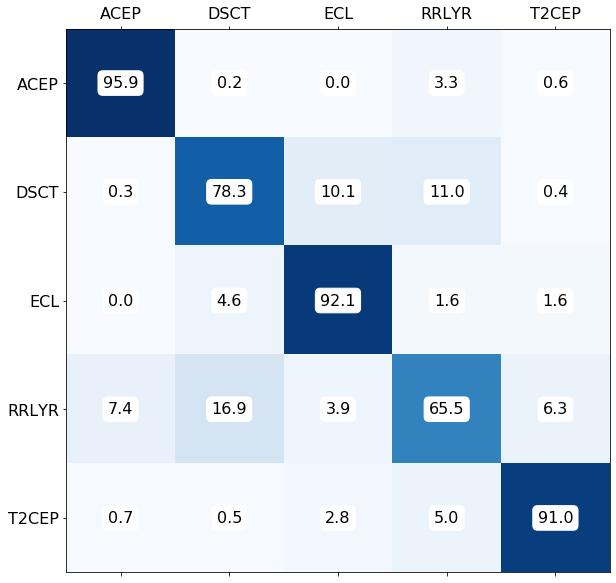

In [17]:
# Confusion matrix for OGLE 3 data
# These were the result for the folded light curves:
# predictions = [ [99.2, 0.0, 0.0, 0.7, 0.1],
#                 [0.1, 90.4, 5.2, 4.0, 0.3],
#                 [0.0, 0.9, 99.0, 0.1, 0.0],
#                 [3.3, 5.0, 0.1, 89.7, 1.9],
#                 [0.2, 0.1, 0.0, 0.5, 99.2]]

# Unfolded light curves


predictions = [ [95.9, 0.2, 0.0, 3.3, 0.6],
                [0.3, 78.3, 10.1, 11.0, 0.4],
                [0.0, 4.6, 92.1, 1.6, 1.6],
                [7.4, 16.9, 3.9, 65.5, 6.3],
                [0.7, 0.5, 2.8, 5.0, 91.0]]

# plt.matshow(predictions,cmap='Blues')
labels = ['ACEP', 'DSCT', 'ECL', 'RRLYR', 'T2CEP']

fig = plt.figure(figsize=(10, 10), dpi=72,)
ax = fig.add_subplot(111)
cax = ax.matshow(predictions, interpolation='nearest', cmap='Blues')
# fig.colorbar(mappable,'cax')

ax.set_xticklabels(['']+labels)
ax.set_yticklabels(['']+labels)

ax.tick_params(axis='both', which='major', labelsize=16)

for (i, j), z in np.ndenumerate(predictions):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center', fontsize=16,
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='1'))

plt.show()

In [ ]:
# Confusion matrix for OGLE 4 data

dsct = [0.01, 89.85, 2.98, 6.77, 0.38]

predictions = [ [80.16, 2.34, 0.00, 10.67, 6.83],
                [0, 0, 0, 0, 0],
                [0.00, 1.56, 98.24, 0.12, 0.08],
                [6.89, 5.10, 0.12, 83.44, 4.45],
                [5.12, 3.51, 0.70, 5.44, 85.24]]

# plt.matshow(predictions,cmap='Blues')
labels = ['ACEP', 'DSCT', 'ECL', 'RRLYR', 'T2CEP']

fig = plt.figure(figsize=(10, 10), dpi=72,)
ax = fig.add_subplot(111)
cax = ax.matshow(predictions, interpolation='nearest', cmap='Blues')
# fig.colorbar(mappable,'cax')

ax.set_xticklabels(['']+labels)
ax.set_yticklabels(['']+labels)

ax.tick_params(axis='both', which='major', labelsize=14)

for (i, j), z in np.ndenumerate(predictions):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center', fontsize=16,
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='1'))

plt.show()

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Summaries for histogram

k = tf.placeholder(tf.float32)
# Make a normal distribution, with a shifting mean
mean_moving_normal = tf.random_normal(shape=[100], mean=(5*k), stddev=1)
# Record that distribution into a histogram summary
tf.summary.histogram("normal/moving_mean", mean_moving_normal)


In [ ]:
array1 = np.array([[82.48, 0.00, 0.50, 14.34, 2.68],
[0.05, 90.73, 7.72, 0.95, 0.55],
[0.00, 1.20, 98.50, 0.00, 0.30],
[10.85, 3.69, 0.02, 81.09, 4.35],
[5.40, 0.44, 0.00, 11.77, 82.38]
])

array2 = np.array([[81.12, 0.00, 0.60, 15.53, 2.75],
[0.11, 92.92, 5.67, 0.75, 0.55],
[0.00, 1.62, 98.08, 0.05, 0.25],
[8.66, 4.33, 0.05, 82.22, 4.73],
[5.55, 0.47, 0.87, 12.13, 80.98]
])

array3 = np.array([[73.39, 0.00, 0.00, 10.33, 16.27],
[0.15, 94.23, 1.02, 3.21, 1.40],
[0.00, 2.07, 97.48, 0.15, 0.30],
[6.89, 2.58, 0.20, 83.38, 6.95],
[1.16, 1.00, 2.00, 8.72, 87.12],
])

array4 = np.array([[78.90, 0.00, 0.00, 5.95, 15.15],
[0.10, 95.36, 0.65, 2.40, 1.49],
[0.00, 2.45, 97.05, 0.05, 0.45],
[8.45, 3.05, 0.20, 79.72, 8.58],
[2.05, 1.00, 2.00, 5.48, 89.47]
])

#sum_avg = (array1 + array2)/2
sum_avg = (array1 + array2 + array3 + array4)/4

print(sum_avg)



In [ ]:


prediction = np.array([0,0,0,0,0])

for img,per in zip(X_Img_test[y_Img_test[:,0] == 1 ], X_Ptext_test[y_Img_test[:,0] == 1 ]):
    # print(img)
    img_size = 128
    periodData = np.array([per])
    # img = image.load_img(img, target_size=(img_size, img_size))
    # img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
#     print(model.predict(img))
    prediction = prediction + model.predict([img,periodData])
    # print(periodData)

print(prediction/np.sum(prediction)*100)

In [ ]:
float_formatter = lambda x: "%.2f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})

prediction = np.array([0,0,0,0,0])

for img,per in zip(X_Img_test[y_Img_test[:,1] == 1 ], X_Ptext_test[y_Img_test[:,1] == 1 ]):
    # print(img)
    img_size = 128
    periodData = np.array([per])
    # img = image.load_img(img, target_size=(img_size, img_size))
    # img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
#     print(model.predict(img))
    prediction = prediction + model.predict([img,periodData])
    # print(periodData)

print(prediction/np.sum(prediction)*100)

In [ ]:
float_formatter = lambda x: "%.2f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})

prediction = np.array([0,0,0,0,0])

for img,per in zip(X_Img_test[y_Img_test[:,2] == 1 ], X_Ptext_test[y_Img_test[:,2] == 1 ]):
    # print(img)
    img_size = 128
    periodData = np.array([per])
    # img = image.load_img(img, target_size=(img_size, img_size))
    # img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
#     print(model.predict(img))
    prediction = prediction + model.predict([img,periodData])
    # print(periodData)

print(prediction/np.sum(prediction)*100)

In [ ]:
float_formatter = lambda x: "%.2f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})

prediction = np.array([0,0,0,0,0])

for img,per in zip(X_Img_test[y_Img_test[:,3] == 1 ], X_Ptext_test[y_Img_test[:,3] == 1 ]):
    # print(img)
    img_size = 128
    periodData = np.array([per])
    # img = image.load_img(img, target_size=(img_size, img_size))
    # img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
#     print(model.predict(img))
    prediction = prediction + model.predict([img,periodData])
    # print(periodData)

print(prediction/np.sum(prediction)*100)

In [ ]:
float_formatter = lambda x: "%.2f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})

prediction = np.array([0,0,0,0,0])

for img,per in zip(X_Img_test[y_Img_test[:,4] == 1 ], X_Ptext_test[y_Img_test[:,4] == 1 ]):
    # print(img)
    img_size = 128
    periodData = np.array([per])
    # img = image.load_img(img, target_size=(img_size, img_size))
    # img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
#     print(model.predict(img))
    prediction = prediction + model.predict([img,periodData])
    # print(periodData)

print(prediction/np.sum(prediction)*100)

In [57]:
len(failed)

1301

In [55]:
# testimg = 'ogle4test/acep_058.png' 

failed_full = []

for testimg in failed:
    filename = testimg
    prediction = np.array([0,0,0,0,0])
    testimg = image.load_img('ogle4test/' + testimg, target_size=(img_size, img_size))
    testimg = image.img_to_array(testimg)
    testimg = np.expand_dims(testimg, axis=0)

    pred = prediction + model.predict(testimg)[0]
    subtest = np.array([filename,pred])
    failed_full.append(subtest)

In [53]:
len(failed_full)

1301

In [54]:
for i in range(len(failed_full)):
    print(failed_full[i][0],"-", failed_full[i][1])

acep_003.png - [0.07 0.80 0.00 0.12 0.01]
acep_003_clone_0.png - [0.01 0.96 0.00 0.02 0.00]
acep_003_clone_1.png - [0.11 0.69 0.00 0.18 0.01]
acep_003_clone_10.png - [0.08 0.62 0.00 0.27 0.02]
acep_003_clone_11.png - [0.02 0.88 0.00 0.08 0.01]
acep_003_clone_12.png - [0.05 0.62 0.00 0.32 0.00]
acep_003_clone_13.png - [0.07 0.72 0.00 0.17 0.04]
acep_003_clone_14.png - [0.09 0.53 0.00 0.35 0.03]
acep_003_clone_15.png - [0.07 0.79 0.00 0.12 0.02]
acep_003_clone_2.png - [0.03 0.88 0.00 0.08 0.00]
acep_003_clone_3.png - [0.04 0.81 0.00 0.13 0.01]
acep_003_clone_4.png - [0.04 0.79 0.00 0.14 0.02]
acep_003_clone_5.png - [0.06 0.76 0.00 0.17 0.01]
acep_003_clone_6.png - [0.08 0.75 0.00 0.15 0.02]
acep_003_clone_7.png - [0.06 0.82 0.00 0.09 0.02]
acep_003_clone_8.png - [0.11 0.62 0.00 0.25 0.02]
acep_003_clone_9.png - [0.15 0.67 0.00 0.15 0.03]
acep_024.png - [0.02 0.00 0.00 0.98 0.00]
acep_024_clone_0.png - [0.06 0.00 0.00 0.94 0.00]
acep_024_clone_1.png - [0.03 0.00 0.00 0.97 0.00]
acep_024_c

dsct_2605_clone_8.png - [0.00 0.19 0.81 0.00 0.00]
dsct_2616.png - [0.00 0.13 0.87 0.00 0.00]
dsct_2616_clone_0.png - [0.00 0.15 0.85 0.00 0.00]
dsct_2616_clone_1.png - [0.00 0.28 0.72 0.00 0.00]
dsct_2616_clone_2.png - [0.00 0.38 0.62 0.00 0.00]
dsct_2616_clone_4.png - [0.00 0.27 0.73 0.00 0.00]
dsct_2616_clone_6.png - [0.00 0.33 0.67 0.00 0.00]
dsct_2616_clone_7.png - [0.00 0.16 0.84 0.00 0.00]
dsct_2618.png - [0.00 0.02 0.00 0.98 0.00]
dsct_2618_clone_0.png - [0.00 0.01 0.00 0.99 0.00]
dsct_2618_clone_1.png - [0.00 0.01 0.00 0.99 0.00]
dsct_2618_clone_2.png - [0.00 0.23 0.00 0.77 0.00]
dsct_2618_clone_3.png - [0.00 0.03 0.00 0.97 0.00]
dsct_2618_clone_4.png - [0.00 0.03 0.00 0.97 0.00]
dsct_2618_clone_5.png - [0.00 0.02 0.00 0.98 0.00]
dsct_2618_clone_6.png - [0.00 0.01 0.00 0.99 0.00]
dsct_2618_clone_7.png - [0.00 0.06 0.00 0.94 0.00]
dsct_2620.png - [0.00 0.24 0.00 0.61 0.15]
dsct_2620_clone_2.png - [0.00 0.20 0.00 0.25 0.55]
dsct_2620_clone_3.png - [0.00 0.39 0.00 0.19 0.42]
dsct

t2cep_004_clone_7.png - [0.10 0.01 0.00 0.40 0.49]
t2cep_006.png - [1.00 0.00 0.00 0.00 0.00]
t2cep_006_clone_0.png - [0.97 0.00 0.00 0.00 0.03]
t2cep_006_clone_1.png - [1.00 0.00 0.00 0.00 0.00]
t2cep_006_clone_2.png - [0.99 0.00 0.00 0.00 0.01]
t2cep_006_clone_4.png - [0.74 0.00 0.00 0.00 0.26]
t2cep_006_clone_5.png - [0.67 0.00 0.00 0.00 0.33]
t2cep_006_clone_6.png - [0.88 0.00 0.00 0.00 0.12]
t2cep_006_clone_7.png - [1.00 0.00 0.00 0.00 0.00]
t2cep_014.png - [0.00 0.41 0.00 0.56 0.03]
t2cep_014_clone_0.png - [0.00 0.40 0.00 0.42 0.18]
t2cep_014_clone_1.png - [0.00 0.42 0.00 0.43 0.15]
t2cep_014_clone_2.png - [0.00 0.43 0.00 0.46 0.11]
t2cep_014_clone_3.png - [0.00 0.47 0.00 0.47 0.06]
t2cep_014_clone_4.png - [0.00 0.49 0.00 0.40 0.11]
t2cep_014_clone_5.png - [0.00 0.48 0.00 0.50 0.02]
t2cep_014_clone_6.png - [0.00 0.36 0.00 0.57 0.06]
t2cep_014_clone_7.png - [0.00 0.37 0.00 0.60 0.03]
t2cep_017.png - [0.26 0.43 0.04 0.16 0.12]
t2cep_017_clone_0.png - [0.24 0.40 0.03 0.21 0.12]
t2ce